In [27]:
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline import CustomFactor, CustomFilter, Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.classifiers.fundamentals import Sector 
import pandas as pd
import statsmodels.tsa.stattools as ts
from quantopian.pipeline.filters.morningstar import Q500US
from quantopian.pipeline import Pipeline
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from quantopian.pipeline import CustomFilter
from quantopian.pipeline.experimental import QTradableStocksUS
from quantopian.pipeline.data.psychsignal import stocktwits
import quantopian.pipeline.factors as factor


In [29]:
def normalize_multiarray(multyarray):
    
    # Si en caso el array es multiarray, lo transponemos
    if multyarray.shape[0] != 1:
        multyarray = multyarray.transpose()
        
    multiarray_normalized = []
        
    for array in multyarray:
        # Normalizamos el array obviando los nans (los dejamos como tal)
        array_normalized = array / np.linalg.norm(array[~np.isnan(array)])
        multiarray_normalized.append(array_normalized)
        
    multiarray_normalized = np.array(multiarray_normalized)
    
    # Si en caso el array es multiarray, lo transponemos
    if multyarray.shape[0] != 1:
        multiarray_normalized = multiarray_normalized.transpose()
    
    return multiarray_normalized

In [30]:
class abs_factor(CustomFactor):
    window_length = 1
    def compute(self, today, asset_ids, out, info):
        out[:] = np.abs(info)

class normalized_factor(CustomFactor):
    window_length = 1
    def compute(self, today, asset_ids, out, info):
        out[:] = normalize_multiarray(info)

In [31]:
def make_pipeline():
    universe = QTradableStocksUS()
    
    daily_returns = factor.DailyReturns([USEquityPricing.close])
    abs_daily_returns = abs_factor([daily_returns])
    
    volumen = USEquityPricing.volume.latest
    normalized_volumen = normalized_factor([volumen])
    
    sentiment_score = stocktwits.bull_minus_bear.latest
    
    rsi_15 = factor.RSI([USEquityPricing.close])
    
    return Pipeline(columns={"volumen": volumen, 
                             "normalized_volumen": normalized_volumen,
                            "sentiment_score": sentiment_score,
                            "abs_daily_returns": abs_daily_returns,
                            "rsi_15": rsi_15}, screen=universe)

In [32]:
# Import run_pipeline method
from quantopian.research import run_pipeline

# Specify a time range to evaluate
period_start = '2019-01-25'
period_end = '2019-07-30'

# Execute pipeline over evaluation period
pipeline_output = run_pipeline(make_pipeline(), start_date=period_start, end_date=period_end)

In [33]:
sym = symbols('AAPL')

In [34]:
one_stock_info = pipeline_output.xs(sym, level=1, drop_level=False)

In [35]:
def plot_correlation_levels(factor_1, factor_1_name, factor_2, factor_2_name, paso = 5):
    lista = []

    for i in range(1, factor_1.shape[0], paso):
        correlacion = np.corrcoef(factor_1.values[i:i + paso], factor_2.values[i:i + paso])
        lista.append(correlacion[0,1])

    plt.title('Correlacion entre {} y {}, agrupado en grupos de {}'.format(factor_1_name, factor_2_name, paso))

    plt.plot(lista)

In [36]:
def plot_two(factor_1, factor_1_name, factor_2, factor_2_name):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(np.array(factor_1), color = "g")
    ax1.tick_params(axis='y', labelcolor="g")
    ax1.set_ylabel(factor_1_name, color="g")

    ax2.plot(np.array(factor_2), color = "r")
    ax2.tick_params(axis='y', labelcolor="r")
    ax2.grid(False)
    ax2.set_ylabel(factor_2_name, color="r")
    
    plt.title('{} vs {}'.format(factor_1_name, factor_2_name))
    plt.show()

    plot_correlation_levels(factor_1, factor_1_name, factor_2, factor_2_name)


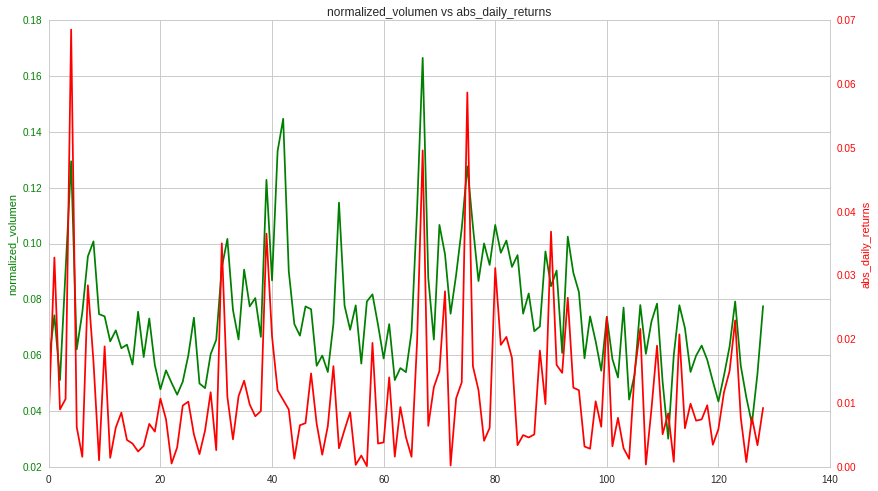

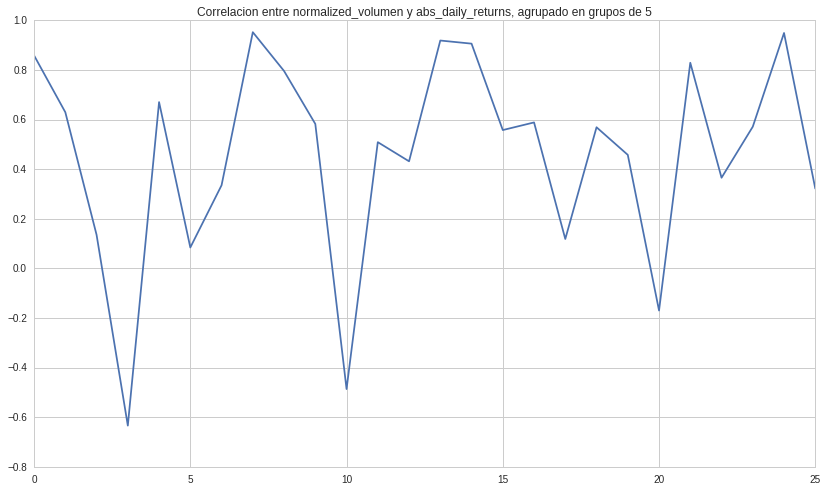

In [37]:
plot_two(one_stock_info.normalized_volumen, "normalized_volumen", one_stock_info.abs_daily_returns, "abs_daily_returns")

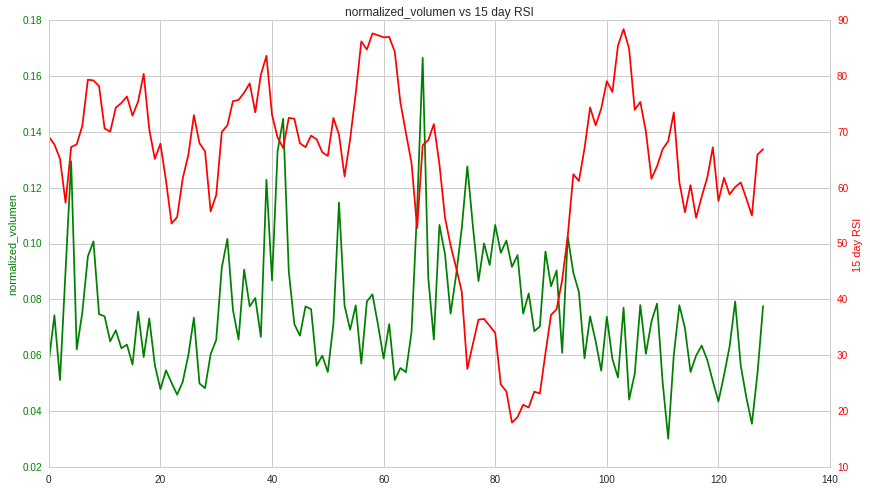

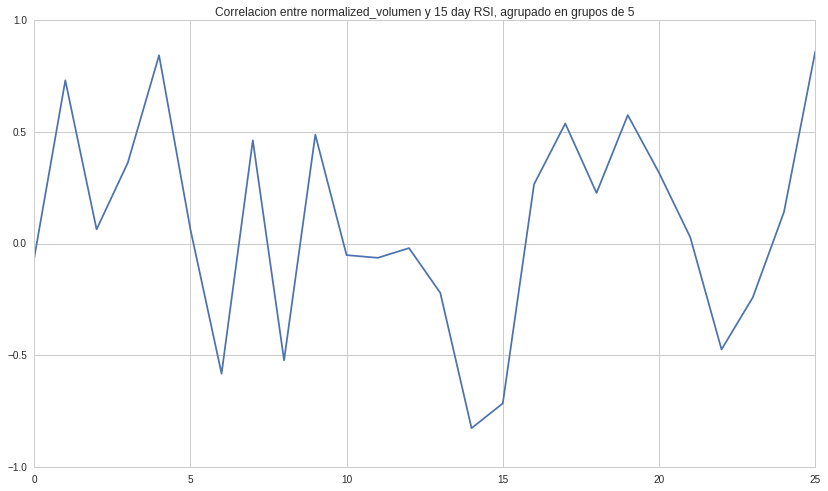

In [38]:
plot_two(one_stock_info.normalized_volumen, "normalized_volumen", one_stock_info.rsi_15, "15 day RSI")

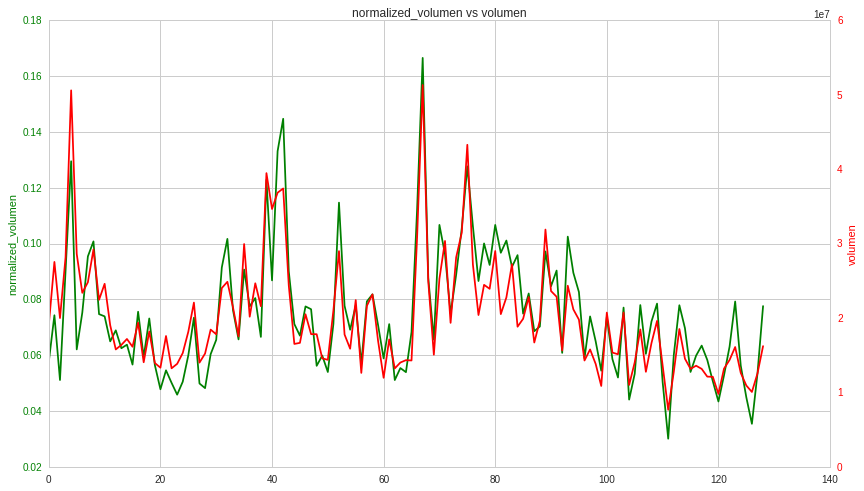

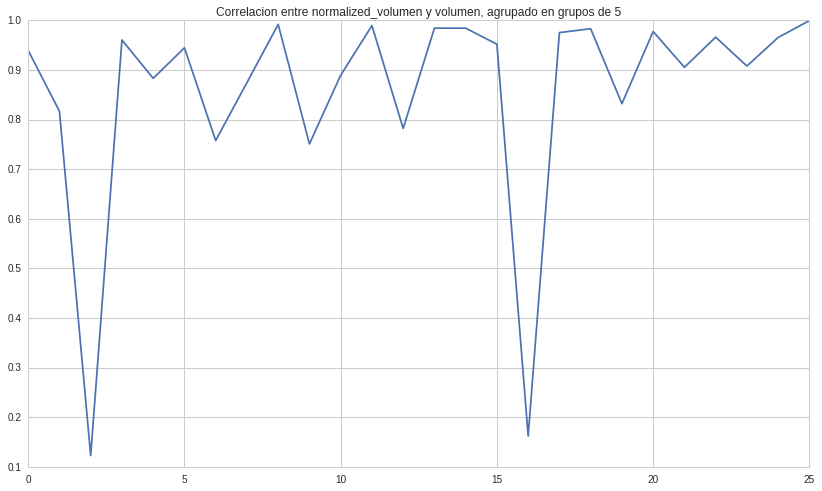

In [39]:
plot_two(one_stock_info.normalized_volumen, "normalized_volumen", one_stock_info.volumen, "volumen")